# Part 0: Imports and Functions: All Of Them

In [4]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import requests
import random
import math
from collections import defaultdict
import time
from torch.utils.data import Dataset, DataLoader

In [5]:
if torch.mps.is_available():
    device = torch.device('mps')
elif torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [6]:
def train_val_split(data, val_fraction = 0.1):
    random.seed(123)
    random.shuffle(data)
    val_count = int(val_fraction * len(data))
    val = data[:val_count]
    train = data[val_count:]
    return train, val

def make_x_y(words, max_len, stoi, start_token = ''):
    """
    Generates input (x) and target (y) data for a language model.

    This function takes a list of words, a string-to-index mapping (stoi),
    and a context size to create context-target pairs for training.
    It pads each word with start tokens and then uses a sliding window
    to generate the context (x) and the target (y) for each position
    in the padded word.

    Args:
        words (list): A list of strings, where each string represents a word or a chunk of text.
        stoi (dict): A dictionary mapping characters to their numerical indices.
        context_size (int): The size of the context window (number of preceding characters
                            to consider for prediction).
        start_token (str, optional): Defaults to '' for books, and should be '$' for names.

    Returns:
        tuple: A tuple containing two PyTorch tensors:
            - x (torch.Tensor): A tensor of shape (num_examples, context_size) representing
                                the input context for each example.
            - y (torch.Tensor): A tensor of shape (num_examples,) representing the target
                                token (to be predicted) for each example.
    """
    x = []
    y = []
    for w in words:
        w = start_token + w
        lst = list(map(lambda a: stoi[a], w)) + [0]*(max_len - len(w))
        lst2 = list(map(lambda a: stoi[a], w)) + [-1]*(max_len - len(w))
        x.append(lst[:-1])
        y.append(lst2[1:])
    x = torch.tensor(x)
    y = torch.tensor(y)
    return x, y

def train_1(model, x_train, y_train, x_val, y_val,
          num_epochs, batch_size, lr, stoi, start_texts, print_every, save_file):

    context_size = x_train.shape[1]

    # Set up data loader for batched training
    train_dataset = torch.utils.data.TensorDataset(x_train, y_train)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # Set up loss function and optimizer
    loss_fn = nn.CrossEntropyLoss(ignore_index=-1)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    min_loss = float("inf")
    losses = []

    ind = 0

    # model = model.to(device)
    # x_train = x_train.to(device)
    # y_train = y_train.to(device)
    # x_val = x_val.to(device)
    # y_val = y_val.to(device)
    


    def snapshot(model):
        nonlocal ind
        # print some statistics for how training is going
        # print a few samples from the generate_text function
        # (you will need to pass in a few more parameters to this
        # function to get generate_text to work. remember for the
        # books data you also need to give starting context.)
        # if (ind % print_every == 0):
        #     print(f"SNAPSHOT {ind//print_every}:")
        #     for i, x in enumerate(start_texts):
        #         print("\t", f"Sample {i}:", generate_text(model.sample, context_size, stoi=stoi, start=x))
        #     pass
        ind += 1
    t1 = time.time()
    for epoch in range(num_epochs):
        # basic logic for training over an epoch
        model.train()

        for batch_x, batch_y in train_loader:

            optimizer.zero_grad()
            scores, _ = model(batch_x)
            loss = loss_fn(scores, batch_y)
            loss.backward()
            optimizer.step()
            snapshot(model)



        # Get the entire validation loss at the end of each epoch
        model.eval()
        with torch.no_grad():
            val_scores, _ = model(x_val)
            val_loss = loss_fn(val_scores, y_val).item()
            print(f"Epoch {epoch} : {val_loss}")
            losses.append(val_loss)
            if val_loss < min_loss:
                min_loss = val_loss
                with open(save_file, "wb") as f:
                    torch.save(model, f)
        model.train()
    t2 = time.time()
    print("Time: ", t2-t1)
    # TODO: create and display a final plot showing loss information
    plt.scatter(np.arange(len(losses)), losses)
    return losses

def generate_text_1(sampling_function, context_size, stoi, start = "", itos = None, max_length = 100, hidden=None):
    # credit to thomas for some syntax help
    """
    Generate text using a given sampling function and context size.

    Args:
        sampling_function (callable): A function that takes a context (list of token IDs)
                                     and returns the next token ID.
        context_size (int): Size of the context window used by the model.
        stoi (dict): String-to-index mapping dictionary to convert characters to token IDs.
        start (str, optional): Initial text to start generation with. Defaults to "".
        itos (dict, optional): Index-to-string mapping dictionary. If None, will be created
                              from stoi. Defaults to None.
        max_length (int, optional): Maximum length of the generated text. Defaults to 100.

    Returns:
        str: The generated text, including the start string if provided.

    Notes:
        - If start is empty, assumes a special start/end token with index 0.
        - Generation stops when max_length is reached or an end token (0) is generated
          (only when start is empty, indicating generation with start/end tokens).
    """
    if itos is None:
        itos = {i:s for s,i in stoi.items()}
    has_end_token = 1 # if there is no starting context, we assume there is a start / end token with index 0
    # initialize context to pad with 0s for start tokens
    context = [0] * (context_size - len(start))
    context += [stoi[c] for c in start][-context_size:]
    output = start
    for _ in range(max_length):
        c2 = torch.tensor(([context]))
        scores, nh = sampling_function(c2, hidden)
        scores = scores[0, :, -1]
        probs = torch.softmax(scores, 0, dtype=torch.float).detach().numpy()
        next_id = np.random.choice(len(probs), p=probs)
        hidden = nh
        if has_end_token and next_id == 0:
            break
        context.pop(0)
        context.append(next_id)
        output += itos[next_id]
    return output

def generate_text(sampling_function, context_size, stoi, start = "", itos = None, max_length = 25, hidden=None, temp=1, has_end_token = 1):
    # credit to thomas for some syntax help
    """
    Generate text using a given sampling function and context size.

    Args:
        sampling_function (callable): A function that takes a context (list of token IDs)
                                     and returns the next token ID.
        context_size (int): Size of the context window used by the model.
        stoi (dict): String-to-index mapping dictionary to convert characters to token IDs.
        start (str, optional): Initial text to start generation with. Defaults to "".
        itos (dict, optional): Index-to-string mapping dictionary. If None, will be created
                              from stoi. Defaults to None.
        max_length (int, optional): Maximum length of the generated text. Defaults to 100.

    Returns:
        str: The generated text, including the start string if provided.

    Notes:
        - If start is empty, assumes a special start/end token with index 0.
        - Generation stops when max_length is reached or an end token (0) is generated
          (only when start is empty, indicating generation with start/end tokens).
    """
    if itos is None:
        itos = {i:s for s,i in stoi.items()}
    # has_end_token = 1 # if there is no starting context, we assume there is a start / end token with index 0
    # initialize context to pad with 0s for start tokens
    context = [0] * (context_size - len(start))
    context += [stoi[c] for c in start][-context_size:]
    output = start
    for _ in range(max_length):
        c2 = torch.tensor(([context]))
        scores, nh = sampling_function(c2, hidden)
        scores = scores[0, :, -1]
        scores /= temp
        probs = torch.softmax(scores, 0, dtype=torch.float).detach().numpy()
        next_id = np.random.choice(len(probs), p=probs)
        hidden = nh
        if has_end_token and next_id == 0:
            break
        context.pop(0)
        context.append(next_id)
        output += itos[next_id]
    return output

def train(model, x_train, y_train, x_val, y_val,
          num_epochs, batch_size, lr, stoi, start_texts, print_every, save_file, temps=[1], is_books = 0):

    context_size = x_train.shape[1]

    # Set up data loader for batched training
    train_dataset = torch.utils.data.TensorDataset(x_train, y_train)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # Set up loss function and optimizer
    loss_fn = nn.CrossEntropyLoss(ignore_index=-1)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    min_loss = float("inf")
    losses = []

    ind = 0
    # hidden = None

    # model = model.to(device)
    # x_train = x_train.to(device)
    # y_train = y_train.to(device)
    # x_val = x_val.to(device)
    # y_val = y_val.to(device)
    

    def snapshot(model):
        nonlocal ind
        # print some statistics for how training is going
        # print a few samples from the generate_text function
        # (you will need to pass in a few more parameters to this
        # function to get generate_text to work. remember for the
        # books data you also need to give starting context.)
        if (ind % print_every == 0):
            print(f"SNAPSHOT {ind//print_every}:")
            for i, x in enumerate(start_texts):
                for j in temps:
                    print("\t", f"Sample {i} with temp {j}:", generate_text(model, context_size, stoi=stoi, start=x, temp=j, has_end_token=not is_books))
        ind += 1
    t1 = time.time()
    prev_time = t1
    for epoch in range(num_epochs):
        # basic logic for training over an epoch
        model.train()

        for batch_x, batch_y in train_loader:

            optimizer.zero_grad()
            # if hidden is not None:
            #     hidden = hidden.detach()
            scores, _ = model(batch_x)
            loss = loss_fn(scores, batch_y)
            loss.backward()
            optimizer.step()
            with torch.no_grad():
                snapshot(model)



        # Get the entire validation loss at the end of each epoch
        model.eval()
        with torch.no_grad():
            val_scores, _ = model(x_val)
            val_loss = loss_fn(val_scores, y_val).item()
            t = time.time()
            etl = (t-t1)/(epoch+1) * (num_epochs - epoch - 1)
            print(f"Epoch {epoch} : {round(val_loss, 5):0<5}, Epoch Time Taken: {round(t-prev_time, 5):0<6}, Expected time remaining: {round(etl, 5):0<6}")
            prev_time = t
            losses.append(val_loss)
            if val_loss < min_loss:
                min_loss = val_loss
                with open(save_file, "wb") as f:
                    torch.save(model, f)
        model.train()
    t2 = time.time()
    print("Time: ", t2-t1)
    # TODO: create and display a final plot showing loss information
    plt.scatter(np.arange(len(losses)), losses)
    return losses

def track_state(text: str, state: np.ndarray | torch.Tensor, bkg: bool = False, mul=1) -> str:
    """
    credit: Jasper Ng
    """
    if isinstance(state, torch.Tensor):
        state = state.numpy(force=True)
        
    out = ["\x1b[0m"]
    state[state < 0] /= -min(0, np.min(state))
    state[state > 0] /= max(0, np.max(state))
    for char, value in zip(text, state[:len(text)]):
        value *= mul
        out.append(
            "\x1b[{}8;2;{};{};{}m{}".format(
                3 + bkg,
                int(255 * (1 + min(value, 0))),
                int(255 * (1 - abs(value))),
                int(255 * (1 + min(-value, 0))),
                char,
            )
        )
    out.append("\x1b[0m")
    return "".join(out)

# Part 1: Reimport names and books datasets and process into x, y

In [7]:

## If running on colab / google drive, will need to mount drive
# from google.colab import drive
# drive.mount('/content/drive')

# with open("NAMES FILE HERE", "r") as f:
#     names = [line.strip() for line in f]
url = "http://www.aayanarish.com/ml_datasets/british_roads.txt"
names = requests.get(url).text.splitlines()
names = [i + "$" for i in names]
random.shuffle(names)

names = [i for i in names if len(i) < 30]

max_names_len = max(len(i) for i in names)
print("Max Name Len:", max_names_len)

url = "http://www.aayanarish.com/ml_datasets/trump_speeches.txt"
books_in = requests.get(url).text
books_in = books_in.replace("â", "").replace("", " ").replace("", " ").replace("", " ").replace("", " ").replace("¦", "")

# Example list of strings
string_list = books_in.split()

# Dictionary to store character counts and first 3 words they appear in
char_data = defaultdict(lambda: {"count": 0, "words": set()})

# Process each word
for word in string_list:
    for char in set(word): # Use set() to avoid duplicate counting in the same word
        char_data[char]["count"] += word.count(char)
        if len(char_data[char]["words"]) < 10:
            char_data[char]["words"].add(word)

# Convert dictionary to sorted list by frequency (descending)
sorted_char_data = sorted(char_data.items(), key=lambda x: x[1]["count"], reverse=True)

chars = []

# Print results
for char, data in sorted_char_data:
    print(f"'{char}': {data['count']} | First 10 words: {', '.join(data['words'])}")
    if data['count'] > 1000:
        chars.append(char)

chars = sorted(chars)

vocab_books1 = sorted(list(set(books_in)))
books = books_in
for x in vocab_books1:
    if books.count(x) < 1000:
        books = books.replace(x, "")
vocab_books = sorted(list(set(books)))
vocab_names = sorted(list(set(''.join(names)))) # names has the special start / end token

stoi_books = {s:i for i,s in enumerate(vocab_books)}
itos_books = {i:s for s,i in stoi_books.items()}

stoi_names = {s:i for i,s in enumerate(vocab_names)}
itos_names = {i:s for s,i in stoi_names.items()}

print(f"names uses {len(vocab_names)} characters: {''.join(vocab_names)}")
print(f"books uses {len(vocab_books)} characters: {''.join(vocab_books)}")

#@title Split into training and validation set
train_names, val_names = train_val_split(names)

## We are splitting books into 1000 even chunks, of which 10% will become validation
## This is lazily just splitting characters evenly, since the gaps will be neglible.
## Feel free to make the split be more intelligently between words or sentences.
# num_book_chunks = 1000
# chunk_size = math.ceil(len(books) / num_book_chunks)
chunk_size = 200
book_chunks = [books[i:i + chunk_size] for i in range(0, len(books), chunk_size)]
train_books, val_books = train_val_split(book_chunks)

## again need all these variables
## now they are no longer dictionaries with a variety of context sizes
## each should just be a single PyTorch tensor

#@title Process datasets into x, y to train models

x_train_books, y_train_books = make_x_y(train_books, chunk_size, stoi_books)
x_val_books, y_val_books = make_x_y(val_books, chunk_size, stoi_books)
x_train_names, y_train_names = make_x_y(train_names, max_names_len+1, stoi_names, start_token = '$')
x_val_names, y_val_names = make_x_y(val_names, max_names_len+1, stoi_names, start_token = '$')
# x_train_books = DataLoader(x_train_books, 1024)
# x_train_names = DataLoader(x_train_names, 1024)
# y_train_books = DataLoader(y_train_books, 1024)
# y_train_names = DataLoader(y_train_names, 1024)
# x_val_books = DataLoader(x_val_books, 1024)
# x_val_names = DataLoader(x_val_names, 1024)
# y_val_books = DataLoader(y_val_books, 1024)
# y_val_names = DataLoader(y_val_names, 1024)


Max Name Len: 29
'e': 1650784 | First 10 words: minister, white, please., are, house, prime, honored, welcome, very, the
't': 1314236 | First 10 words: minister, white, to, first, thank, netanyahu, emirates,, netanyahu., united, the
'a': 1089619 | First 10 words: sara., thank, israel,, please., are, and, netanyahu, netanyahu., lady, abdullah
'o': 1084207 | First 10 words: to, you., foreign, house, of, you, honored, welcome, you,, so
'i': 931316 | First 10 words: minister, white, first, israel,, foreign, emirates,, prime, united, i, bin
'n': 923059 | First 10 words: minister, thank, foreign, and, netanyahu, honored, netanyahu., united, bin, zayani
'r': 731777 | First 10 words: minister, sara., first, israel,, are, mrs., foreign, prime, honored, very
's': 727641 | First 10 words: minister, sara., first, israel,, please., mrs., house, this, emirates,, so
'h': 720526 | First 10 words: white, much., thank, house, netanyahu, bahrain., honored, netanyahu., abdullah, the
'l': 536091 | First 10

# Part 2: Define RNN class

This will be a [nn.Module](https://pytorch.org/docs/stable/generated/torch.nn.Module.html). The modules you will build it out of are the same [nn.Embedding](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html) and [nn.Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) you have already been using, along with [nn.Tanh](https://pytorch.org/docs/stable/generated/torch.nn.Tanh.html) for the nonlinearity.

In [8]:
class RNN(nn.Module):

    def __init__(self, vocab_size, embed_dim=16, hidden_size=256):
        super().__init__()
        self.hidden_size = hidden_size
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        ## create all necessary layers here
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.l1 = nn.Linear(hidden_size, hidden_size)
        self.l2 = nn.Linear(embed_dim, hidden_size)
        self.l3 = nn.Linear(hidden_size, vocab_size)
        self.tanh = nn.Tanh()

    # def to(self, device):
    #     self.embedding = self.embedding.to(device)
    #     self.l1 = self.l1.to(device)
    #     self.l2 = self.l2.to(device)
    #     self.l3 = self.l3.to(device)
    #     self.tanh = self.tanh.to(device)
    #     return super().to(device)

    def forward(self, x, hidden=None):
        """
            x: (batch_size, seq_len) of token IDs
            hidden: (batch_size, hidden_size) or None,
                the intial hidden states, with otherwise will start as zeros

        Returns:
            scores: (batch_size, vocab_size, seq_len)
            hidden: (batch_size, hidden_size) final hidden states
        """
        batch_size, seq_len = x.shape
        if hidden is None:
            hidden = torch.zeros((batch_size, self.hidden_size))
        embedded = self.embedding(x) # (batch_size, seq_len, embedding_dim) 
        scores = torch.zeros((batch_size, self.vocab_size, seq_len))
        for i in range(seq_len):
            hidden = self.tanh(self.l1(hidden) + self.l2(embedded[:,i,:])) # (batch_size, hidden_size)
            scores[..., i] = self.l3(hidden) # (batch_size, vocab_size)
        return scores, hidden

    def count_params(self):
        """Count the number of trainable parameters in the model."""
        return sum(p.numel() for p in self.parameters() if p.requires_grad)
    


class torch_RNN(nn.Module):

    def __init__(self, vocab_size, embed_dim=16, hidden_size=256, layers=1, dropout=0):
        super().__init__()
        self.hidden_size = hidden_size
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.num_layers = layers
        ## create all necessary layers here
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.rnn = nn.RNN(embed_dim, hidden_size, batch_first=True, num_layers=layers, dropout=dropout)
        self.l3 = nn.Linear(hidden_size, vocab_size)

    def forward(self, x, hidden=None):
        """
            x: (batch_size, seq_len) of token IDs
            hidden: (batch_size, hidden_size) or None,
                the intial hidden states, with otherwise will start as zeros

        Returns:
            scores: (batch_size, vocab_size, seq_len)
            hidden: (batch_size, hidden_size) final hidden states
        """
        # print(len(x))
        batch_size, seq_len = x.shape
        # print(batch_size, seq_len)
        if hidden is None:
            hidden = torch.zeros((self.num_layers, batch_size, self.hidden_size))
        # assert hidden.shape == (self.num_layers, batch_size, self.hidden_size), (x.shape, hidden.shape, (self.num_layers, batch_size, self.hidden_size))
        embedded = self.embedding(x) # (batch_size, seq_len, embedding_dim) 
        scores = torch.zeros((batch_size, self.vocab_size, seq_len))
        pred, hidden = self.rnn(embedded, hidden)
        scores = self.l3(pred)
        scores = torch.transpose(scores, 1, 2)
        return scores, hidden

    def count_params(self):
        """Count the number of trainable parameters in the model."""
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

class torch_LSTM(nn.Module):
    def __init__(self, vocab_size, embed_dim=16, hidden_size=256, layers=1, dropout=0):
        super().__init__()
        self.hidden_size = hidden_size
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.num_layers = layers
        ## create all necessary layers here
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.rnn = nn.LSTM(embed_dim, hidden_size, batch_first=True, num_layers=layers, dropout=dropout)
        self.l3 = nn.Linear(hidden_size, vocab_size)

    def forward(self, x, hidden=None):
        """
            x: (batch_size, seq_len) of token IDs
            hidden: (batch_size, hidden_size) or None,
                the intial hidden states, with otherwise will start as zeros

        Returns:
            scores: (batch_size, vocab_size, seq_len)
            hidden: (batch_size, hidden_size) final hidden states
        """
        batch_size, seq_len = x.shape
        # print(batch_size, seq_len)
        if hidden is None:
            hidden = (torch.zeros((self.num_layers, batch_size, self.hidden_size)), torch.zeros((self.num_layers, batch_size, self.hidden_size)))
        embedded = self.embedding(x) # (batch_size, seq_len, embedding_dim) 
        scores = torch.zeros((batch_size, self.vocab_size, seq_len))
        pred, hidden = self.rnn(embedded, hidden)
        scores = self.l3(pred)
        scores = torch.transpose(scores, 1, 2)
        return scores, hidden

    def count_params(self):
        """Count the number of trainable parameters in the model."""
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

# Part 3: Simple Train Function

This will mostly be the same logic you have before. The main difference is in how you apply [nn.CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html).

You will now need to use the `ignore_index` feature, since your $y$ is padded with an ignore index.

SNAPSHOT 0:
	 Sample 0: yphobhxkuedemfvtghtvugwcity_gkwbvpowfhqpayotewujqjbqensuimts_
SNAPSHOT 1:
	 Sample 0: cclosl
SNAPSHOT 2:
	 Sample 0: erriwhygtoa_etrwmhor_rtanic
SNAPSHOT 3:
	 Sample 0: rifeestwwloue
SNAPSHOT 4:
	 Sample 0: iejgwey_aydvenl
SNAPSHOT 5:
	 Sample 0: engrth_lrodd
SNAPSHOT 6:
	 Sample 0: resthse_srivt
SNAPSHOT 7:
	 Sample 0: orden_lood
SNAPSHOT 8:
	 Sample 0: acotl_road
SNAPSHOT 9:
	 Sample 0: arm_road_gardens
SNAPSHOT 10:
	 Sample 0: eesnder_place
SNAPSHOT 11:
	 Sample 0: lan_bard_street
SNAPSHOT 12:
	 Sample 0: enchens_roagh
SNAPSHOT 13:
	 Sample 0: arkin_avenhe_road
SNAPSHOT 14:
	 Sample 0: lustine_road
SNAPSHOT 15:
	 Sample 0: reowey_avenue
SNAPSHOT 16:
	 Sample 0: aldis_walk
SNAPSHOT 17:
	 Sample 0: andale_road
SNAPSHOT 18:
	 Sample 0: ars_wal
SNAPSHOT 19:
	 Sample 0: htoy_close
SNAPSHOT 20:
	 Sample 0: mellyck_street
SNAPSHOT 21:
	 Sample 0: r_sfield_road
SNAPSHOT 22:
	 Sample 0: rin_close
SNAPSHOT 23:
	 Sample 0: rtth_close
SNAPSHOT 24:
	 Sample 0: arn_close
S

[1.3502793312072754,
 1.2754846811294556,
 1.2388960123062134,
 1.2139192819595337,
 1.1970977783203125,
 1.1880160570144653,
 1.1754932403564453,
 1.1687324047088623,
 1.1624599695205688,
 1.1568596363067627,
 1.1553654670715332,
 1.1509875059127808,
 1.144840121269226,
 1.1423509120941162,
 1.1429262161254883,
 1.1394953727722168,
 1.136329174041748,
 1.1355379819869995,
 1.131682276725769,
 1.1315546035766602]

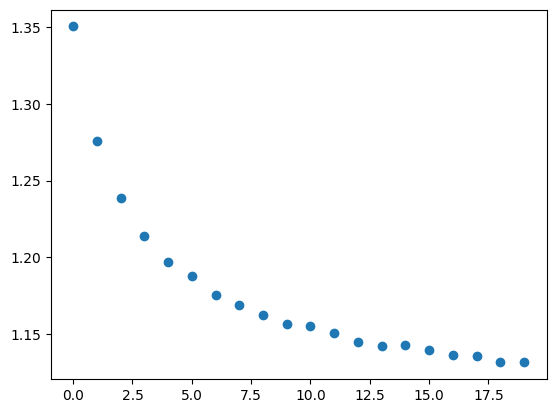

In [239]:
moodle = RNN(len(vocab_names))
train_1(moodle, x_train_names, y_train_names, x_val_names, y_val_names, 20, 100, 0.001, stoi_names, [""], 20, "kebab_boom.pkl")

In [ ]:
# datum = [len(x) for x in names]
# print(sum([datum.count(x) for x in range(30, 46)])/len(names))
# plt.hist(datum)

# Part 4: Sampling Function

### ok sampling

In [251]:
for _ in range(20):
    print(generate_text_1(moodle, 5, stoi_names, ""))

ler_road
arl_close
hae_road
brook
hae_gardent_close
ia_road
ters_yard
heale_ridines
lier_court_stree
lia_walk
haby_flaid_cross_gardens_drive
ian_mews
hart_close
horn_stree
merie_road
a_roundastrey
rom_road
n_range_strick
field_rocin
line_mews


### Some temperature

#### temp = 3 = gibberish

In [257]:
for _ in range(20):
    print(generate_text(moodle, 5, stoi_names, "", temp=3))

lahakaterlact
anax_leouz
mustry
_rugbey_gyriu
rorstbrnel
kirct
ca_roadw
aia
aare
ferbus_slew_chlose_glmdyd_wood_tzisg_lemgesol_pgace_geo
vewsh_flundy_wracim_rourt_d
celus_haslaastees
lebnr
lsea_hibce
tkchipaguw_walrusdbexberfz_szaloh_wnints_wstise_dmitullo_cairar_yomptuds
reewhryywstinckew_vunpoop
crof_cisppy
vi_rnoxde
cycowary
ersfribatreydidn


#### temp = 0.5 = interesting

In [264]:
for _ in range(20):
    print(generate_text(moodle, 5, stoi_names, "", temp=0.5))

har_road
ar_way
ia_stree
le_chase_drive
roe_seysway
ler_road
ar_road
lare_road
lier_road
ar_close
ore_gate
ne_road
har_walk
mere_road
ler_close
ree_chase_close
land_road
ler_road
ne_road
ar_close


#### temp = 0.1 = communist

In [265]:
for _ in range(20):
    print(generate_text(moodle, 5, stoi_names, "", temp=0.1))

har_road
har_close
lier_road
ler_road
lier_road
lier_road
ar_close
lier_road
lier_road
ar_close
ar_court_roust_road
ler_road
har_road
har_road
lier_close
lier_close
lier_close
lier_close
lier_road
lier_road


# Part 5: Add Sampling to Train Function, do actual training

SNAPSHOT 0:
	 Sample 0 with temp 1: iz_dg
	 Sample 0 with temp 0.5: rhmesdao_
	 Sample 0 with temp 2: nvzrhzpke_xizsod_qsdzlvqhsis_o_sqwccxnen
SNAPSHOT 1:
	 Sample 0 with temp 1: rangroor_grrove
	 Sample 0 with temp 0.5: bingf_road
	 Sample 0 with temp 2: chesbeladrrskt
SNAPSHOT 2:
	 Sample 0 with temp 1: anscbewaac
	 Sample 0 with temp 0.5: se_avenue
	 Sample 0 with temp 2: suuottor_mqitl
SNAPSHOT 3:
	 Sample 0 with temp 1: ghilmas_street
	 Sample 0 with temp 0.5: ley_avenue
	 Sample 0 with temp 2: bgethedte__eanem_st_mestbcroshongs
SNAPSHOT 4:
	 Sample 0 with temp 1: ope_road
	 Sample 0 with temp 0.5: ston_crescent
	 Sample 0 with temp 2: gias_zobslaye_tquroe
SNAPSHOT 5:
	 Sample 0 with temp 1: assrill_street
	 Sample 0 with temp 0.5: ston_road
	 Sample 0 with temp 2: ling_hdanaw
SNAPSHOT 6:
	 Sample 0 with temp 1: lands_street
	 Sample 0 with temp 0.5: sta_place
	 Sample 0 with temp 2: bugczelputnl
SNAPSHOT 7:
	 Sample 0 with temp 1: ton_street
	 Sample 0 with temp 0.5: ot_road
	 Sa

[1.2887976169586182,
 1.2344751358032227,
 1.207721471786499,
 1.1961950063705444,
 1.181182622909546,
 1.175938606262207,
 1.1773052215576172,
 1.169205904006958,
 1.1686376333236694,
 1.16975998878479,
 1.168382167816162,
 1.1653468608856201,
 1.1655678749084473,
 1.1644233465194702,
 1.168882131576538,
 1.1672031879425049,
 1.1695044040679932,
 1.1636204719543457,
 1.1645727157592773,
 1.1666052341461182]

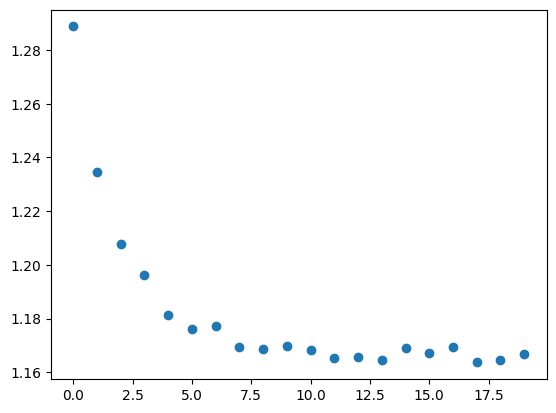

In [268]:
names_moodle_1 = RNN(len(vocab_names))
train(names_moodle_1, x_train_names, y_train_names, x_val_names, y_val_names, 20, 100, 0.003, stoi_names, [""], 30, "aayan_moo1_names.pkl", [1, 0.5, 2])

SNAPSHOT 0:
	 Sample 0 with temp 0.1: sepdjrucnt_ouuuuudivruvyuialkfknodqn_zrlvialasw__
	 Sample 0 with temp 0.5: acwwciuszsmiyvv_vvxemdlblm
	 Sample 0 with temp 1: s
	 Sample 0 with temp 1.5: vmpvsebrvrusj
	 Sample 0 with temp 2: lbzrpi_xgtnr
SNAPSHOT 1:
	 Sample 0 with temp 0.1: erten_road
	 Sample 0 with temp 0.5: osade_coust
	 Sample 0 with temp 1: ellcn_road
	 Sample 0 with temp 1.5: ae_oaud
	 Sample 0 with temp 2: aajcprnjpouxt_gdozxssbvlohpp_wuee
SNAPSHOT 2:
	 Sample 0 with temp 0.1: er_close
	 Sample 0 with temp 0.5: hille_grree
	 Sample 0 with temp 1: _gtarsensliles_read
	 Sample 0 with temp 1.5: arhmrevvrahe
	 Sample 0 with temp 2: iaps_uelk
SNAPSHOT 3:
	 Sample 0 with temp 0.1: all_close
	 Sample 0 with temp 0.5: ew_road
	 Sample 0 with temp 1: inktlel_crovt
	 Sample 0 with temp 1.5: illoot_aapehjrtod_caond
	 Sample 0 with temp 2: _krdstone
SNAPSHOT 4:
	 Sample 0 with temp 0.1: linga_close
	 Sample 0 with temp 0.5: ine_road
	 Sample 0 with temp 1: erley_darnan_crose
	 Sample

[1.4384582042694092,
 1.3404542207717896,
 1.2949780225753784,
 1.2658774852752686,
 1.2462114095687866,
 1.2284706830978394,
 1.216196894645691,
 1.2049349546432495,
 1.1979289054870605,
 1.1877644062042236,
 1.1808667182922363,
 1.1763776540756226,
 1.1695371866226196,
 1.165923833847046,
 1.1624094247817993,
 1.1596198081970215,
 1.1551340818405151,
 1.1505972146987915,
 1.1493011713027954,
 1.1497814655303955,
 1.1464828252792358,
 1.1436432600021362,
 1.1423901319503784,
 1.1408627033233643,
 1.139723777770996,
 1.136904239654541,
 1.1365388631820679,
 1.1352578401565552,
 1.1329001188278198,
 1.1311126947402954,
 1.1308197975158691,
 1.1285629272460938,
 1.1287791728973389,
 1.128279447555542,
 1.127673864364624,
 1.1281253099441528,
 1.1268807649612427,
 1.1260764598846436,
 1.125002145767212,
 1.1235439777374268]

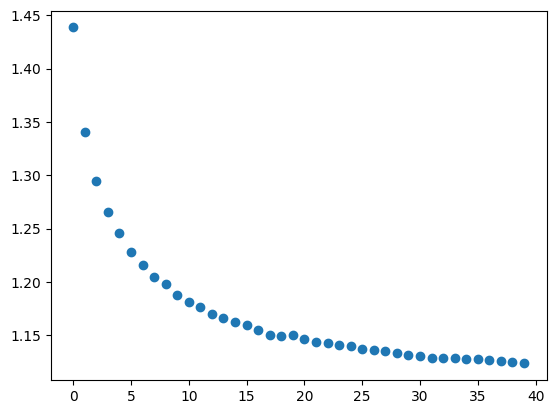

In [271]:
names_moodle_2 = RNN(len(vocab_names))
train(names_moodle_2, x_train_names, y_train_names, x_val_names, y_val_names, 40, 100, 0.0005, stoi_names, [""], 100, "aayan_moo2_names.pkl", [0.1, 0.5, 1, 1.5, 2])

SNAPSHOT 0:
	 Sample 0 with temp 0.1: 
	 Sample 0 with temp 0.5: dp
	 Sample 0 with temp 1: dcvqt_mrvrxqdgzzohhwriylspxnasm_uweoxyfphfjqgbhreubpm
	 Sample 0 with temp 1.5: tfeviq
	 Sample 0 with temp 2: 
Epoch 0 : 2.38266, Epoch Time Taken: 4.77567, Expected time remaining: 472.79134
SNAPSHOT 1:
	 Sample 0 with temp 0.1: road
	 Sample 0 with temp 0.5: ertosengt_ll_st
	 Sample 0 with temp 1: nnlganadue
	 Sample 0 with temp 1.5: vrev_tuposideyer_mony_muoppkalrsele_rnopffaydvtnus_jcreve
	 Sample 0 with temp 2: lmanatn_izsoleoway
Epoch 1 : 2.03744, Epoch Time Taken: 4.55633, Expected time remaining: 457.268
SNAPSHOT 2:
	 Sample 0 with temp 0.1: ron_street
	 Sample 0 with temp 0.5: enroat
	 Sample 0 with temp 1: nnemy_ltee
	 Sample 0 with temp 1.5: iroh_stireen_ploleu
	 Sample 0 with temp 2: bghoendrayducnms_lrnks
Epoch 2 : 1.8612, Epoch Time Taken: 4.89301, Expected time remaining: 459.94199
SNAPSHOT 3:
	 Sample 0 with temp 0.1: ron_street
	 Sample 0 with temp 0.5: en_road
	 Sample 0 with 

[2.382659912109375,
 2.037442445755005,
 1.861202597618103,
 1.7592836618423462,
 1.6883026361465454,
 1.6340112686157227,
 1.590139627456665,
 1.5540813207626343,
 1.5238170623779297,
 1.4982976913452148,
 1.4759979248046875,
 1.456207275390625,
 1.4393525123596191,
 1.4232999086380005,
 1.4091671705245972,
 1.3963967561721802,
 1.3847622871398926,
 1.3740490674972534,
 1.3641655445098877,
 1.3557230234146118,
 1.3469226360321045,
 1.3390750885009766,
 1.3320201635360718,
 1.325149416923523,
 1.3188968896865845,
 1.3131519556045532,
 1.307073712348938,
 1.3021621704101562,
 1.2967894077301025,
 1.2925055027008057,
 1.2876873016357422,
 1.2834362983703613,
 1.2794831991195679,
 1.2752951383590698,
 1.2714847326278687,
 1.2683218717575073,
 1.2644063234329224,
 1.2615607976913452,
 1.2583309412002563,
 1.2551953792572021,
 1.2522778511047363,
 1.2494654655456543,
 1.2466257810592651,
 1.2443286180496216,
 1.241519570350647,
 1.2397767305374146,
 1.2370171546936035,
 1.2349655628204346,


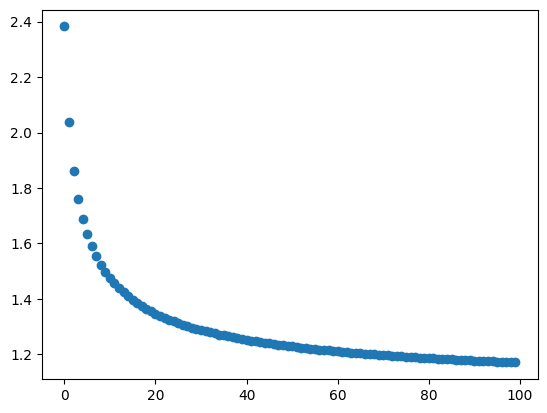

In [275]:
names_moodle_3 = RNN(len(vocab_names))
train(names_moodle_3, x_train_names, y_train_names, x_val_names, y_val_names, 100, 1024, 0.0002, stoi_names, [""], 100, "aayan_moo3_names.pkl", [0.1, 0.5, 1, 1.5, 2])

Notice, not very good roads. This is because the model does not have good memory, meaning it thinks its always at the end of the road name (first word) and hence ends it and switches to a road suffix (road, lane, part)

In [318]:

for _ in range(20):
    print(generate_text(names_moodle_3, 5, stoi_names, ""))

n_road
le_park
e_chase
rne_lane
nn_counter_tuart_road
ne_avenuer
n_down
ris_court
nnaua_dowl
nn_clos
ne_roadway
le_alre
rus_road
ry_clos
rine_place
le_chard
le_stree
er_road
es_clos
s_dens


SNAPSHOT 0:
	 Sample 0 with temp 0.1: jrvyysbtrererdserogk
	 Sample 0 with temp 0.5: ekciyhxbstfeazzadmpqcmhllwysyenlpsytgdcbbmrihuek
	 Sample 0 with temp 1: vpmvsjhx
	 Sample 0 with temp 1.5: zo
	 Sample 0 with temp 2: sztlxxpsphhd
Epoch 0 : 1.75853, Epoch Time Taken: 4.89565, Expected time remaining: 239.88706
SNAPSHOT 1:
	 Sample 0 with temp 0.1: len_road
	 Sample 0 with temp 0.5: lleis_grescent
	 Sample 0 with temp 1: manerrta_ctode
	 Sample 0 with temp 1.5: lzeote_avlvenv_morez
	 Sample 0 with temp 2: nurnstzeat_cuftd
Epoch 1 : 1.54387, Epoch Time Taken: 3.9547, Expected time remaining: 212.40862
SNAPSHOT 2:
	 Sample 0 with temp 0.1: ston_road
	 Sample 0 with temp 0.5: ans_street
	 Sample 0 with temp 1: ssugington_poad
	 Sample 0 with temp 1.5: tim_flack
	 Sample 0 with temp 2: veys_lane
Epoch 2 : 1.44926, Epoch Time Taken: 3.85956, Expected time remaining: 199.122
SNAPSHOT 3:
	 Sample 0 with temp 0.1: ther_close
	 Sample 0 with temp 0.5: ster_street
	 Sample 0 with temp 1: at_mew

[1.758528232574463,
 1.543866753578186,
 1.449257731437683,
 1.3914457559585571,
 1.3546123504638672,
 1.325392723083496,
 1.3038434982299805,
 1.2856330871582031,
 1.2709773778915405,
 1.2583870887756348,
 1.2473934888839722,
 1.2374016046524048,
 1.228891134262085,
 1.2216789722442627,
 1.2145979404449463,
 1.2074335813522339,
 1.2026278972625732,
 1.196324110031128,
 1.192699670791626,
 1.1891915798187256,
 1.184611439704895,
 1.1804841756820679,
 1.1785526275634766,
 1.173509955406189,
 1.1723039150238037,
 1.1683868169784546,
 1.1655677556991577,
 1.1656434535980225,
 1.1618475914001465,
 1.1581259965896606,
 1.1581357717514038,
 1.1562907695770264,
 1.154858112335205,
 1.152296781539917,
 1.151143193244934,
 1.1495271921157837,
 1.148734450340271,
 1.1476638317108154,
 1.1473931074142456,
 1.1452244520187378,
 1.14301598072052,
 1.1428426504135132,
 1.1406428813934326,
 1.1406413316726685,
 1.1396816968917847,
 1.1394797563552856,
 1.137726902961731,
 1.1370069980621338,
 1.13685

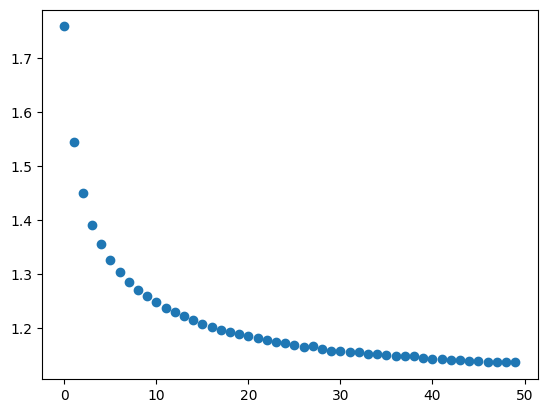

In [277]:
names_moodle_4 = RNN(len(vocab_names))
train(names_moodle_4, x_train_names, y_train_names, x_val_names, y_val_names, 50, 1024, 0.001, stoi_names, [""], 100, "aayan_moo4_names.pkl", [0.1, 0.5, 1, 1.5, 2])

#### Books

SNAPSHOT 0:
	 Sample 0 with temp 0.1: i70tl6$x4o4-tl6$4o.mx598v54a i3dx9 inx4508l6$phmf ibfi37t-9a6einwzqx0i7it-qx0ihdt-qt,$%7nx0..ds i7kw
	 Sample 0 with temp 0.5: 6znx%ki,py66hagmf 2rfpk8.q 9$e  2chsnmfd oycxrxn2m52t ?jpoo4d11-6$7ebffi2qe0ls5,xp qik,?kd1n,-dru6wj
	 Sample 0 with temp 1: c2s8%tlw5?qtewgrqf4ocmwwx6qhs.l7 ,t0r?pg6qcfitoq?kikhh%lwvic%ydbmh5ctmzc8y6l67%v$x7iuda,43ms%,rzxr%?
	 Sample 0 with temp 1.5: 1kanh99?y7te7ls7,3yb0,5cw.q.qbf2a76w9y$9%n0t4u?%0dwenwu69p0w1c2ac2bjff1xpo5gm8sx0$e,6dth$077r24b4jmu
	 Sample 0 with temp 2: $gkr%q%1fk4f,wz9b.qv51ddb-qjeqppf$-%qx1tils8j0w%3x2prffuwce293hg,f,d1supjs6oitcr64%.xblpi - fgmat%5e
	 Sample 1 with temp 0.1: mexico.cqxbfi37nx05c7n inx0il6$?i7eifqx0i7ed.qx59nw inxlib59$nx0nx0i7d4?x559a eni7nxvytr549.fi3dx5cx47nx01
	 Sample 1 with temp 0.5: mexico8h%k%wu ll3485o47d2?bfdz0528ve1e$un  .l?3ipkdl648wz9iws slde%za,xv5ilvo.d5eov%ges3u8kq%j5o.jo4re03rq
	 Sample 1 with temp 1: mexicoy3haz6itj$36d%7awairoo,n,%nt2,%dfe j2jox7?55chb7ni?-o-7,8 he3

[2.4011213779449463,
 2.1926321983337402,
 2.043255567550659,
 1.918134331703186,
 1.813702940940857]

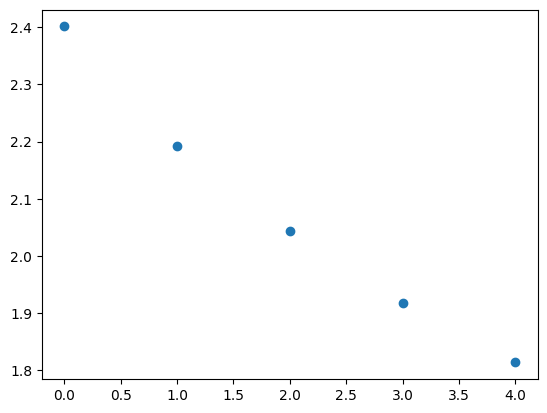

In [313]:
books_moodle_1 = RNN(len(vocab_books))
train(books_moodle_1, x_train_books, y_train_books, x_val_books, y_val_books, 5, 2048, 0.001, stoi_books, ["", "mexico", "biden", "border"], 10, "aayan_moo1_books.pkl", [0.1, 0.5, 1, 1.5, 2], 1)

# Part 6: More Complicated RNN class (multiple layers / LSTM architecture)

## Speed test

SNAPSHOT 0:
	 Sample 0 with temp 1: hrgiueadsszr
SNAPSHOT 1:
	 Sample 0 with temp 1: aaneoi_hoab_
SNAPSHOT 2:
	 Sample 0 with temp 1: ooeno_tane
SNAPSHOT 3:
	 Sample 0 with temp 1: lantoagt
SNAPSHOT 4:
	 Sample 0 with temp 1: aimen_roud
SNAPSHOT 5:
	 Sample 0 with temp 1: amboroad_wilf
SNAPSHOT 6:
	 Sample 0 with temp 1: ailea_way
SNAPSHOT 7:
	 Sample 0 with temp 1: annbury_privc_road
SNAPSHOT 8:
	 Sample 0 with temp 1: reroale_read
SNAPSHOT 9:
	 Sample 0 with temp 1: angntaad
SNAPSHOT 10:
	 Sample 0 with temp 1: inss_vatt
SNAPSHOT 11:
	 Sample 0 with temp 1: benann_road
SNAPSHOT 12:
	 Sample 0 with temp 1: rorkf_atbento__rian
SNAPSHOT 13:
	 Sample 0 with temp 1: e_stroet_rtteet
SNAPSHOT 14:
	 Sample 0 with temp 1: strom_road
SNAPSHOT 15:
	 Sample 0 with temp 1: anrry_avenue
SNAPSHOT 16:
	 Sample 0 with temp 1: inhill_w
SNAPSHOT 17:
	 Sample 0 with temp 1: annole_close
SNAPSHOT 18:
	 Sample 0 with temp 1: iacas_sark_cartace
SNAPSHOT 19:
	 Sample 0 with temp 1: arrad_road
SNAPSHOT 20:
	

[1.3593037128448486,
 1.2835739850997925,
 1.2441186904907227,
 1.2172503471374512,
 1.1984007358551025,
 1.1848324537277222,
 1.1775310039520264,
 1.1704509258270264,
 1.1657636165618896,
 1.156467318534851,
 1.1531424522399902,
 1.1485042572021484,
 1.1461327075958252,
 1.1448477506637573,
 1.1404756307601929,
 1.1426109075546265,
 1.1345566511154175,
 1.1338810920715332,
 1.1335983276367188,
 1.1319541931152344]

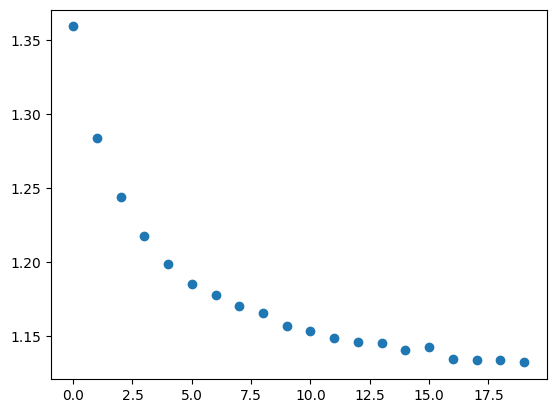

In [320]:
bleh1 = RNN(len(vocab_names))
train(bleh1, x_train_names, y_train_names, x_val_names, y_val_names, 20, 100, 0.001, stoi_names, [""], 20, "dontsave.pkl")

SNAPSHOT 0:
	 Sample 0 with temp 1: fdwjkffyvulopklo
SNAPSHOT 1:
	 Sample 0 with temp 1: een_rcevmusaueuhopfinejtrrsjelr
SNAPSHOT 2:
	 Sample 0 with temp 1: lolpl_pav
SNAPSHOT 3:
	 Sample 0 with temp 1: retriw_dvnvvo_chone
SNAPSHOT 4:
	 Sample 0 with temp 1: eklol_clane
SNAPSHOT 5:
	 Sample 0 with temp 1: rtaml__road
SNAPSHOT 6:
	 Sample 0 with temp 1: rlen_rane
SNAPSHOT 7:
	 Sample 0 with temp 1: roidl_sluee
SNAPSHOT 8:
	 Sample 0 with temp 1: leys_gowd
SNAPSHOT 9:
	 Sample 0 with temp 1: edlan_close
SNAPSHOT 10:
	 Sample 0 with temp 1: rey_close
SNAPSHOT 11:
	 Sample 0 with temp 1: fodg_gardens
SNAPSHOT 12:
	 Sample 0 with temp 1: onme_street
SNAPSHOT 13:
	 Sample 0 with temp 1: selivh_road
SNAPSHOT 14:
	 Sample 0 with temp 1: foun_drive
SNAPSHOT 15:
	 Sample 0 with temp 1: atber_road
SNAPSHOT 16:
	 Sample 0 with temp 1: le_arpver_tleebtrer_cnuster_close
SNAPSHOT 17:
	 Sample 0 with temp 1: leala_close
SNAPSHOT 18:
	 Sample 0 with temp 1: ble_crofe
SNAPSHOT 19:
	 Sample 0 with temp 1

[1.4210495948791504,
 1.3152958154678345,
 1.2694165706634521,
 1.237336277961731,
 1.218998908996582,
 1.2027243375778198,
 1.1954842805862427,
 1.1860061883926392,
 1.17513906955719,
 1.168937087059021,
 1.1640815734863281,
 1.1623972654342651,
 1.1557167768478394,
 1.152541995048523,
 1.1505182981491089,
 1.1455950736999512,
 1.1460891962051392,
 1.1436213254928589,
 1.141919493675232,
 1.139159083366394]

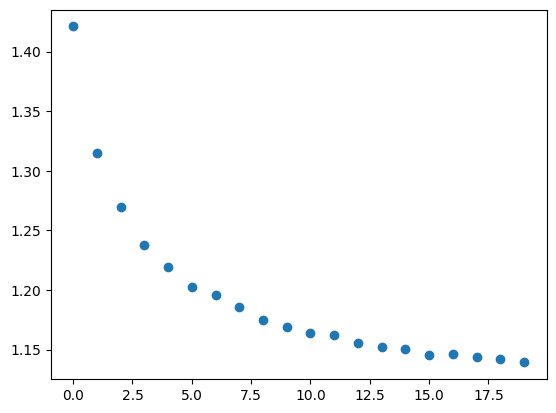

In [351]:
bleh2 = torch_RNN(len(vocab_names))
train(bleh2, x_train_names, y_train_names, x_val_names, y_val_names, 20, 100, 0.001, stoi_names, [""], 20, "dontsave.pkl")

## MultiLayered/LSTM




### RNN

SNAPSHOT 0:
	 Sample 0 with temp 1: wxhgncsukekuehficmatd
SNAPSHOT 1:
	 Sample 0 with temp 1: eotaed
SNAPSHOT 2:
	 Sample 0 with temp 1: eea
SNAPSHOT 3:
	 Sample 0 with temp 1: _k
SNAPSHOT 4:
	 Sample 0 with temp 1: earer
Epoch 0 : 2.62499, Epoch Time Taken: 34.65548, Expected time remaining: 1005.00889
SNAPSHOT 5:
	 Sample 0 with temp 1: n_entce
SNAPSHOT 6:
	 Sample 0 with temp 1: rrssraww_tere_tork
SNAPSHOT 7:
	 Sample 0 with temp 1: rone
SNAPSHOT 8:
	 Sample 0 with temp 1: etreei_oone
Epoch 1 : 2.01543, Epoch Time Taken: 33.99915, Expected time remaining: 961.16479
SNAPSHOT 9:
	 Sample 0 with temp 1: lone
SNAPSHOT 10:
	 Sample 0 with temp 1: ease
SNAPSHOT 11:
	 Sample 0 with temp 1: soude
SNAPSHOT 12:
	 Sample 0 with temp 1: taws_wase_voust
Epoch 2 : 1.77792, Epoch Time Taken: 33.63065, Expected time remaining: 920.56746
SNAPSHOT 13:
	 Sample 0 with temp 1: lanen_close
SNAPSHOT 14:
	 Sample 0 with temp 1: oudse_dasw
SNAPSHOT 15:
	 Sample 0 with temp 1: ortare_ape
SNAPSHOT 16:
	 Samp

[2.6249852180480957,
 2.015430212020874,
 1.777916431427002,
 1.6925491094589233,
 1.598894476890564,
 1.5513546466827393,
 1.4835313558578491,
 1.4425008296966553,
 1.404439926147461,
 1.3681588172912598,
 1.3421119451522827,
 1.320110559463501,
 1.2980196475982666,
 1.2830865383148193,
 1.2649165391921997,
 1.2493804693222046,
 1.2379343509674072,
 1.2276469469070435,
 1.2157219648361206,
 1.2100286483764648,
 1.1986134052276611,
 1.196137547492981,
 1.1850236654281616,
 1.1747541427612305,
 1.1699568033218384,
 1.1685590744018555,
 1.1587305068969727,
 1.1563187837600708,
 1.1526789665222168,
 1.1430600881576538]

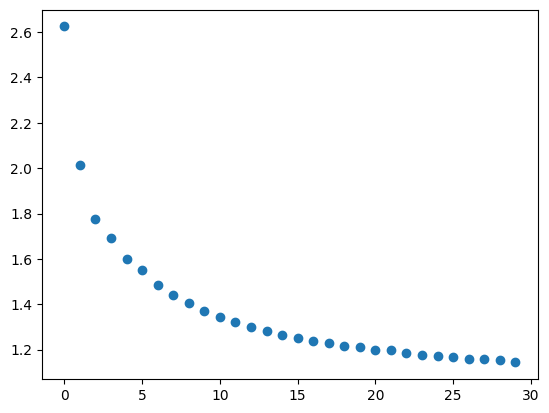

In [361]:
names_fancy_1 = torch_RNN(len(vocab_names), layers=10)
train(names_fancy_1, x_train_names, y_train_names, x_val_names, y_val_names, 30, 1024, 0.0005, stoi_names, [""], 20, "aayan_fancy1_names.pkl")

SNAPSHOT 0:
	 Sample 0 with temp 1: c_prfsheajb_hnkz_ea_pohvj
SNAPSHOT 1:
	 Sample 0 with temp 1: _sb_oyuona_oor
SNAPSHOT 2:
	 Sample 0 with temp 1: ardseco
SNAPSHOT 3:
	 Sample 0 with temp 1: r_ciuaybntrh_wass
SNAPSHOT 4:
	 Sample 0 with temp 1: nar_closed
Epoch 0 : 1.7843, Epoch Time Taken: 24.12443, Expected time remaining: 699.60844
SNAPSHOT 5:
	 Sample 0 with temp 1: _road
SNAPSHOT 6:
	 Sample 0 with temp 1: _crescent
SNAPSHOT 7:
	 Sample 0 with temp 1: _close
SNAPSHOT 8:
	 Sample 0 with temp 1: _pri
Epoch 1 : 1.47821, Epoch Time Taken: 24.56393, Expected time remaining: 681.63702
SNAPSHOT 9:
	 Sample 0 with temp 1: l_getfe
SNAPSHOT 10:
	 Sample 0 with temp 1: _road
SNAPSHOT 11:
	 Sample 0 with temp 1: _morkhew
SNAPSHOT 12:
	 Sample 0 with temp 1: _estas
Epoch 2 : 1.36912, Epoch Time Taken: 24.3307, Expected time remaining: 657.17153
SNAPSHOT 13:
	 Sample 0 with temp 1: _pard
SNAPSHOT 14:
	 Sample 0 with temp 1: _close
SNAPSHOT 15:
	 Sample 0 with temp 1: _avenue
SNAPSHOT 16:
	 Sa

[1.7843022346496582,
 1.4782050848007202,
 1.36911940574646,
 1.3076801300048828,
 1.2605082988739014,
 1.2278668880462646,
 1.2027145624160767,
 1.191487431526184,
 1.1721558570861816,
 1.1589144468307495,
 1.1454941034317017,
 1.1345399618148804,
 1.1260766983032227,
 1.1210993528366089,
 1.1115875244140625,
 1.1087895631790161,
 1.1066232919692993,
 1.09823477268219,
 1.0932589769363403,
 1.0934116840362549,
 1.086668610572815,
 1.0844322443008423,
 1.0849311351776123,
 1.0826574563980103,
 1.0808602571487427,
 1.0781201124191284,
 1.0766448974609375,
 1.076048493385315,
 1.071374535560608,
 1.0714051723480225]

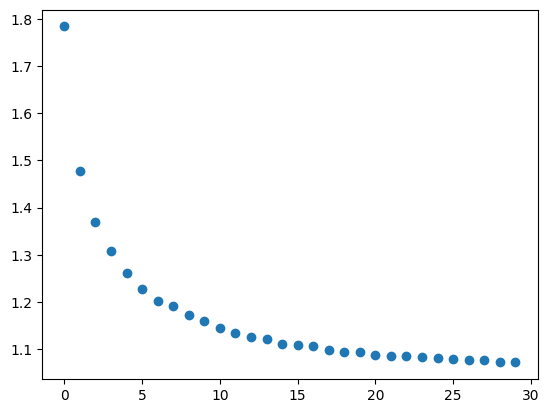

In [362]:
names_fancy_2 = torch_RNN(len(vocab_names), layers=7)
train(names_fancy_2, x_train_names, y_train_names, x_val_names, y_val_names, 30, 1024, 0.001, stoi_names, [""], 20, "aayan_fancy2_names.pkl")

SNAPSHOT 0:
	 Sample 0 with temp 1: wnstmhdnpqndjiolzzfz
SNAPSHOT 1:
	 Sample 0 with temp 1: dyneeuuibaerravear
SNAPSHOT 2:
	 Sample 0 with temp 1: icirotcfrepp_yuap
SNAPSHOT 3:
	 Sample 0 with temp 1: rrorchord_grove
SNAPSHOT 4:
	 Sample 0 with temp 1: oys_rave
Epoch 0 : 1.78346, Epoch Time Taken: 24.39476, Expected time remaining: 829.42171
SNAPSHOT 5:
	 Sample 0 with temp 1: ostere_carlace
SNAPSHOT 6:
	 Sample 0 with temp 1: fense_chort
SNAPSHOT 7:
	 Sample 0 with temp 1: iedlea_road
SNAPSHOT 8:
	 Sample 0 with temp 1: emel_avenue
Epoch 1 : 1.48349, Epoch Time Taken: 23.10123, Expected time remaining: 783.68371
SNAPSHOT 9:
	 Sample 0 with temp 1: arnedprivon_road
SNAPSHOT 10:
	 Sample 0 with temp 1: ocwen_close
SNAPSHOT 11:
	 Sample 0 with temp 1: ollach_ride_gardens
SNAPSHOT 12:
	 Sample 0 with temp 1: eal_grovefouddene
Epoch 2 : 1.37689, Epoch Time Taken: 24.11205, Expected time remaining: 763.819
SNAPSHOT 13:
	 Sample 0 with temp 1: or_bilm_road
SNAPSHOT 14:
	 Sample 0 with temp 

[1.7834627628326416,
 1.4834911823272705,
 1.3768935203552246,
 1.3138339519500732,
 1.2748456001281738,
 1.242139458656311,
 1.220070242881775,
 1.200283408164978,
 1.1876293420791626,
 1.170469045639038,
 1.1606905460357666,
 1.159947395324707,
 1.1429824829101562,
 1.1365422010421753,
 1.128482460975647,
 1.122273325920105,
 1.1174544095993042,
 1.1142245531082153,
 1.1124318838119507,
 1.1066464185714722,
 1.1026018857955933,
 1.1005401611328125,
 1.0964124202728271,
 1.0941028594970703,
 1.0901166200637817,
 1.0878175497055054,
 1.0877466201782227,
 1.08493971824646,
 1.0887988805770874,
 1.08106529712677,
 1.082837462425232,
 1.08100426197052,
 1.0812976360321045,
 1.079715371131897,
 1.0803771018981934]

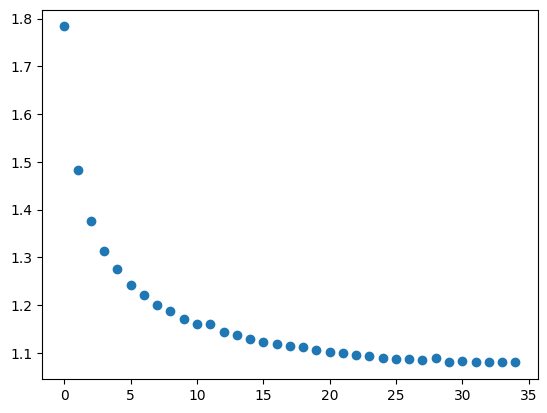

In [9]:
names_fancy_3 = torch_RNN(len(vocab_names), layers=6)
train(names_fancy_3, x_train_names, y_train_names, x_val_names, y_val_names, 35, 1024, 0.0008, stoi_names, [""], 20, "aayan_fancy3_names.pkl")

SNAPSHOT 0:
	 Sample 0 with temp 1: ponesderuisasmlsunjnisufeixrecdzmxbsieu
SNAPSHOT 1:
	 Sample 0 with temp 1: rstyihl_roode
SNAPSHOT 2:
	 Sample 0 with temp 1: _gore_cood
SNAPSHOT 3:
	 Sample 0 with temp 1: re_road
SNAPSHOT 4:
	 Sample 0 with temp 1: e_close
Epoch 0 : 1.70913, Epoch Time Taken: 15.18775, Expected time remaining: 744.19956
SNAPSHOT 5:
	 Sample 0 with temp 1: e_wour_croaq
SNAPSHOT 6:
	 Sample 0 with temp 1: _street
SNAPSHOT 7:
	 Sample 0 with temp 1: _avenue
SNAPSHOT 8:
	 Sample 0 with temp 1: e_drive
Epoch 1 : 1.47718, Epoch Time Taken: 13.94297, Expected time remaining: 699.1373
SNAPSHOT 9:
	 Sample 0 with temp 1: _road
SNAPSHOT 10:
	 Sample 0 with temp 1: _road
SNAPSHOT 11:
	 Sample 0 with temp 1: e_drive
SNAPSHOT 12:
	 Sample 0 with temp 1: e_road
Epoch 2 : 1.37424, Epoch Time Taken: 12.91203, Expected time remaining: 658.66981
SNAPSHOT 13:
	 Sample 0 with temp 1: e_lane
SNAPSHOT 14:
	 Sample 0 with temp 1: e_qoad
SNAPSHOT 15:
	 Sample 0 with temp 1: e_drive
SNAPSH

[1.7091339826583862,
 1.4771829843521118,
 1.3742401599884033,
 1.313019871711731,
 1.2720370292663574,
 1.2460052967071533,
 1.2180132865905762,
 1.2022652626037598,
 1.1850244998931885,
 1.1729028224945068,
 1.1597505807876587,
 1.1488028764724731,
 1.1412968635559082,
 1.1352051496505737,
 1.1258807182312012,
 1.1202020645141602,
 1.1171166896820068,
 1.1109914779663086,
 1.108323574066162,
 1.1037249565124512,
 1.1001819372177124,
 1.0982614755630493,
 1.094802975654602,
 1.0909910202026367,
 1.0926326513290405,
 1.0873435735702515,
 1.0840710401535034,
 1.0821489095687866,
 1.0824897289276123,
 1.0824962854385376,
 1.0785640478134155,
 1.0783385038375854,
 1.077780842781067,
 1.077713966369629,
 1.0736976861953735,
 1.075231671333313,
 1.074596881866455,
 1.0743811130523682,
 1.073570728302002,
 1.0720890760421753,
 1.0727076530456543,
 1.0731220245361328,
 1.071672797203064,
 1.0731834173202515,
 1.0709583759307861,
 1.0731773376464844,
 1.0726473331451416,
 1.0722440481185913,
 

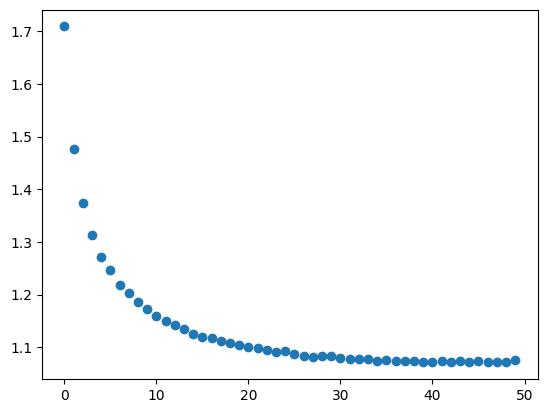

In [172]:
names_fancy_4 = torch_RNN(len(vocab_names), layers=4)
train(names_fancy_4, x_train_names, y_train_names, x_val_names, y_val_names, 50, 1024, 0.0008, stoi_names, [""], 20, "aayan_fancy4_names.pkl")

SNAPSHOT 0:
	 Sample 0 with temp 1: tfzoqxkjjdvcjhfazixehxesmjraet
	 Sample 0 with temp 0.2: sges_uxrklstmufpqjuliohvogdlzia
SNAPSHOT 1:
	 Sample 0 with temp 1: dt
	 Sample 0 with temp 0.2: 
SNAPSHOT 2:
	 Sample 0 with temp 1: 
	 Sample 0 with temp 0.2: 
SNAPSHOT 3:
	 Sample 0 with temp 1: 
	 Sample 0 with temp 0.2: 
SNAPSHOT 4:
	 Sample 0 with temp 1: es
	 Sample 0 with temp 0.2: e
Epoch 0 : 2.77012, Epoch Time Taken: 55.88685, Expected time remaining: 2738.45584
SNAPSHOT 5:
	 Sample 0 with temp 1: rtd
	 Sample 0 with temp 0.2: eeeeee
SNAPSHOT 6:
	 Sample 0 with temp 1: odast
	 Sample 0 with temp 0.2: raeeeeeee
SNAPSHOT 7:
	 Sample 0 with temp 1: llhnw_eaery
	 Sample 0 with temp 0.2: rrrrr_raoe
SNAPSHOT 8:
	 Sample 0 with temp 1: num_hadttl_laowt
	 Sample 0 with temp 0.2: rrr_rrod
Epoch 1 : 2.45604, Epoch Time Taken: 52.37724, Expected time remaining: 2598.33823
SNAPSHOT 9:
	 Sample 0 with temp 1: lte_rloe
	 Sample 0 with temp 0.2: rr_coad
SNAPSHOT 10:
	 Sample 0 with temp 1: s_roar
	

[2.77012038230896,
 2.4560422897338867,
 1.9281232357025146,
 1.6505377292633057,
 1.4928297996520996,
 1.4051637649536133,
 1.34486985206604,
 1.29731023311615,
 1.2635499238967896,
 1.2339270114898682,
 1.2102874517440796,
 1.188324213027954,
 1.1722666025161743,
 1.1579400300979614,
 1.1440794467926025,
 1.1342278718948364,
 1.1251659393310547,
 1.1169507503509521,
 1.1077632904052734,
 1.1035658121109009,
 1.0970865488052368,
 1.0940618515014648,
 1.08837890625,
 1.0856337547302246,
 1.0827070474624634,
 1.0792436599731445,
 1.076209306716919,
 1.0733932256698608,
 1.0720347166061401,
 1.0719752311706543,
 1.0692824125289917,
 1.0659449100494385,
 1.0681201219558716,
 1.066514492034912,
 1.0663931369781494,
 1.0644992589950562,
 1.066078782081604,
 1.0655673742294312,
 1.0676095485687256,
 1.0651119947433472,
 1.066625714302063,
 1.0680233240127563,
 1.0674247741699219,
 1.0701000690460205,
 1.0710283517837524,
 1.0720655918121338,
 1.072805643081665,
 1.0765150785446167,
 1.075438

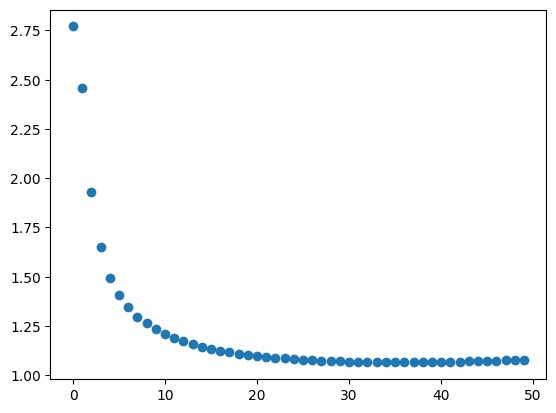

In [173]:
names_fancy_5 = torch_LSTM(len(vocab_names), layers=4)
train(names_fancy_5, x_train_names, y_train_names, x_val_names, y_val_names, 50, 1024, 0.0008, stoi_names, [""], 20, "aayan_fancy5_names.pkl", [1, 0.2])

In [176]:
books_fancy_1 = torch_LSTM(len(vocab_books), layers=4)
train(books_fancy_1, x_train_books, y_train_books, x_val_books, y_val_books, 50, 1024, 0.0008, stoi_books, [""], 20, "aayan_fancy1_book.pkl", [1.5, 1, 0.2, 0.1])

SNAPSHOT 0:
	 Sample 0 with temp 1.5: 3v6673,r8uaplmi,4ldk3k0ajk9fgz?m,yywglc0?bwti0gbt8iq1knzbhf08amx2ohj9klbayd4pv0zaxl%
	 Sample 0 with temp 1: ah7%u3ztrio424.
	 Sample 0 with temp 0.2: 22mcv.yamegsy8-rz1v3
	 Sample 0 with temp 0.1: 306keu-gsh3cmsqu8c
SNAPSHOT 1:
	 Sample 0 with temp 1.5: 
	 Sample 0 with temp 1: 
	 Sample 0 with temp 0.2: 
	 Sample 0 with temp 0.1: 
SNAPSHOT 2:
	 Sample 0 with temp 1.5: yoliinh9aaqwefnmgw
	 Sample 0 with temp 1: igoeleoanhi
	 Sample 0 with temp 0.2: 
	 Sample 0 with temp 0.1: 
SNAPSHOT 3:
	 Sample 0 with temp 1.5: ides,f
	 Sample 0 with temp 1: ottt
	 Sample 0 with temp 0.2: 
	 Sample 0 with temp 0.1: 
Epoch 0 : 2.92742, Epoch Time Taken: 506.18663, Expected time remaining: 24803.14493
SNAPSHOT 4:
	 Sample 0 with temp 1.5: eee
	 Sample 0 with temp 1: ta
	 Sample 0 with temp 0.2: 
	 Sample 0 with temp 0.1: 
SNAPSHOT 5:
	 Sample 0 with temp 1.5: 
	 Sample 0 with temp 1: en
	 Sample 0 with temp 0.2: 
	 Sample 0 with temp 0.1: 
SNAPSHOT 6:
	 Sample 0 w

KeyboardInterrupt: 

SNAPSHOT 0:
	 Sample 0 with temp 1: -9.o?s69-7lqq%t0op?5%x8mw
	 Sample 0 with temp 0.2: e4yltk8dpby1mr4%8t8dvg8?c
	 Sample 0 with temp 0.1: 4,bu%p$pss$eyyj$rzccjuuo9
	 Sample 1 with temp 1: mexicoyfg7022,j6gi 0u.eik.5$948
	 Sample 1 with temp 0.2: mexicoe5ba?pphp7qmeazfhawoxrpa5
	 Sample 1 with temp 0.1: mexicopc9qnovy,dype 6 91%xolpeg
	 Sample 2 with temp 1: joex5zlyh$hco%t8img9q-td$n?j
	 Sample 2 with temp 0.2: joejd$wfwpd99zdekopy1t?4igpb
	 Sample 2 with temp 0.1: joe6e8bnfcdob8518dpu5pr0e66j
	 Sample 3 with temp 1: usguxr. r3-8f7yh t1.s-fulrv
	 Sample 3 with temp 0.2: us%p5fjfp76.c9fmj5y,mjo6t7f
	 Sample 3 with temp 0.1: us4ocerz.dm9wk5cu z9frz3opm
	 Sample 4 with temp 1: illegalc68lma8l4s$34zoi-vpre66rh
	 Sample 4 with temp 0.2: illegal,a4hgju9y39e ,4b1cix-gjb6
	 Sample 4 with temp 0.1: illegalwt5yg,6 666d2td5l4gazdev1
SNAPSHOT 1:
	 Sample 0 with temp 1: hi saih eaa httnh o eiar 
	 Sample 0 with temp 0.2:                          
	 Sample 0 with temp 0.1:                         

[2.927386522293091,
 2.8792946338653564,
 2.613779067993164,
 2.4080612659454346,
 2.2025139331817627,
 2.045262575149536,
 1.9178560972213745,
 1.8327900171279907,
 1.7357795238494873,
 1.6620465517044067,
 1.6133430004119873,
 1.5546419620513916,
 1.52206552028656,
 1.4810484647750854,
 1.4526582956314087,
 1.4252835512161255,
 1.3978174924850464,
 1.3762233257293701,
 1.3587502241134644,
 1.3382289409637451,
 1.3266533613204956,
 1.3059815168380737,
 1.2963560819625854,
 1.2811192274093628,
 1.2671655416488647,
 1.2592159509658813,
 1.2452762126922607,
 1.2343345880508423,
 1.2242704629898071,
 1.2252329587936401,
 1.2065422534942627,
 1.2013416290283203,
 1.1926826238632202,
 1.1831308603286743,
 1.1771777868270874,
 1.1712838411331177,
 1.1657668352127075,
 1.160396933555603,
 1.1613035202026367,
 1.147955298423767]

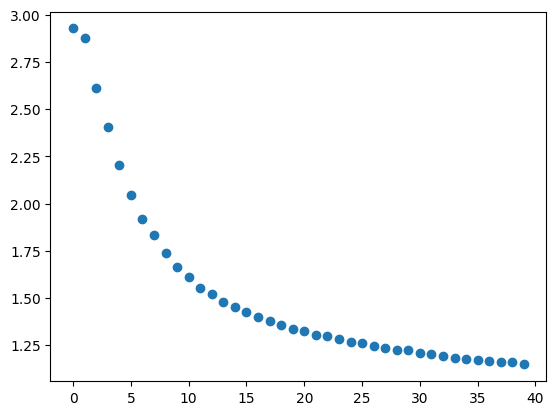

In [182]:
books_fancy_2 = torch_LSTM(len(vocab_books), layers=4)
train(books_fancy_2, x_train_books, y_train_books, x_val_books, y_val_books, 40, 1024, 0.0008, stoi_books, ["", "mexico", "joe", "us", "illegal"], 20, "aayan_fancy2_book.pkl", [1, 0.2, 0.1], 1)

In [198]:
for i in range(20):
    print(generate_text(books_fancy_2, 5, stoi_books, "joe", max_length=100, has_end_token=0, temp=0.5))

joe big the one of the start was on the sending when the less the working in from the tages, and from i
joe biggest controwmen. it s happels win, they befor the socials a subbing is a fantal perfess for they
joe never. it was so me in a terrow for the greaters and the start and we going the plans to the proble
joe. i have working of the story and nothing, they heards. they by that s so many the recoriss. it s go
joe big probled thing. we restors in chart and i won to becaury securess. in they nothing and a lot of 
joe bidens and we very and i do it all of the elect in the compans and we very for that left to becaury
joe billiant our stated him on that a terrors the counts the starting the starting some thing is stated
joe bird a good, and i wants are no comes an and the good, and the other. they by that on with think th
joe. i meaning it s built of the stree starting a counts, as you knew really white too much when in a l
joe big peoply, white you know we happel the last they because i

# Word View Fancy

In [1162]:
def precomp(model, data, dat_idxs, cell=1, ind=3, do_lstm=1):
    t_str = [itos_books[a.item()] for dat_idx in dat_idxs for a in data[dat_idx]]
    ls = [a for dat_idx in dat_idxs for a in data[dat_idx]]
    hidden = None
    xs = []
    for i in range(len(t_str)):
        thing = torch.Tensor([ls[i]]).detach().unsqueeze(0).int()
        # print(model(thing)[1][0].shape)
        with torch.no_grad():
            if do_lstm:
                hidden = model(thing, hidden)[1]
                x = hidden[cell][ind, 0]
            else:
                hidden = model(thing, hidden)[1]
                x = hidden[ind, 0]
        xs.append(x)
    return np.array(xs)

In [1168]:
books_moodle_2 = torch.load("aayan_fancy2_book.pkl", weights_only=False)
# books_moodle_2 = torch.load("aayan_fancy1_book.pkl", weights_only=False)

In [1166]:
dat_idx = 3
dat_idxs = range((dat_idx-1)*500, (dat_idx)*500)
cells = precomp(books_moodle_2, x_train_books, dat_idxs, 1, 3)
hiddens = precomp(books_moodle_2, x_train_books, dat_idxs, 0, 3)
txt = [itos_books[a.item()] for dt_idx in dat_idxs for a in x_train_books[dt_idx]]

In [1058]:
idx = 0

In [268]:
print(len(x_train_books)//50)

1559


In [1136]:
idx -= 2

220 done so far for first, switching to second

In [1169]:
text = "".join(txt)
h = cells
is_whitespace = np.array([1] + [char in "\n\t " for char in text], dtype=bool)
word_index = np.nonzero(is_whitespace)[0]
var_by_word = np.zeros((np.sum(is_whitespace), *h.shape[1:]), dtype=np.float32)
for i, (i0, i1) in enumerate(zip(word_index[:-1], word_index[1:] - 1)):
    if i0 == i1:
        continue
    var_by_word[i] = np.std(np.tanh(h[i0: i1]), axis=0)
scores = np.tanh(np.mean(var_by_word, axis=0)) - np.tanh(np.std(np.tanh(h), axis=0))
for idxx in np.argsort(scores, axis=None)[:20]:
    idxx = np.unravel_index(idxx, h.shape[1:])
    print(idxx)
    idxx = idxx[0]
    print(track_state(text[:1000], h[:, idxx]))

(125,)
 getting a license?  whether it s abc, whether it s nbc, cbs, or of course, cnn. which is i mean one of the great jokes of all time, cnn. or msdnc. but they re cable so i guess there s a different st,  i said, i want every nut. i want every bolt. i want every screw. i want every plane and tank. i want the apaches. i want everything out. and i even want the hangers.  those beautiful canvas hangeric middle class tax cut. it s already biden, all my life i ve been studying politics. i watched it. i was on the other side. i was a contributor to like everybody. they came to my office. i was a con able to be civil. if they re not, you have to fight back. you have to. otherwise we re not going to be. there s a movement on, and i call them the radical left democrats, and it really is the radicad it to congress and to the american people. and it was horrible what he said. and that was supposed to be coming from me, but it was all fabricated. he should resign from office in disgrace. and f

In [1140]:

# # for a in x_train_books[0]:/
#     # print(itos_books[a.item()], end="")
# def do_color_nice(model, data, dat_idxs, idx, lstm=0):
#     t_str = [itos_books[a.item()] for dat_idx in dat_idxs for a in data[dat_idx]]
#     ls = [a for dat_idx in dat_idxs for a in data[dat_idx]]
#     hidden = None
#     xs = []
#     for i in range(len(t_str)):
#         thing = torch.Tensor([ls[i]]).detach().unsqueeze(0).int()
#         # print(model(thing)[1][0].shape)
#         with torch.no_grad():
#             hidden = model(thing, hidden)[1]
#             # print(hidden[1].shape)
#             x = hidden[1]
#         if lstm:
#             x = hidden[1][3, 0, idx]
#         xs.append(x)

print(idx+1)
print(track_state(txt, hiddens[:, idx], mul=1), end="")
# do_color_nice(books_moodle_2, x_train_books, , idx, 1)
idx += 1

64
pens to the criminals that do these terrible things. there is no punishment. but when people who love our country protest on january 6th in washington, they become hostages of our country, unfairly i4%.  where d you hear that? you don t hear that too often. on healthcare, we re providing american families with affordable high quality, personalized healthcare. the washington democrats want bureaud out isis in four weeks, they said it was going to take four to five years. we have great generals, we have great military. they re going to be okay. but on top is woke. how about the changing of thm poland. i want to say yes, of course. i m working on this obvious assumption that by taking part in the research and also by being, in a certain sense, co-creators of the vaccines and therapeutics,n, this is a bill supported by biden, and biden is totally controlled now by the bernie sanders left wing of the party, and in fact he s gone further left than bernie sanders ever dreamt of going. so91

stuff i found in the training data

"a great gentleman, who s just retiring, prime minister abe, of japan. i said,  shinzo, please doracle. larry ellison, it s going to be an incredible combination. and i said,  do me a favor. could you put up $5 billion into a fund for education so we can educate people as to real history of our "

"oakland. they had tremendous baltimore. they had nothing but problems. it was a disaster. and the trade deals were the worst. and the iran deal with $150 ben s here to plan to eliminate our borders, or mini mike s plan to eliminate your second amendment."

"only de and harris have allowed more than 50 radical islamic terrorists, some of the worst in the world, by the way, to cross our border and remain at large in our country and we have no idea where they are the aids epidemic in america within 10 years. isn t that amazing? whoever thought that was possible? who would have thought that s possible? we will defend privacy, free speech, religious liberty, a s strange.  but many people complained and complained vehemently, and in a lot of cases, they filled out a provisional ballot, which was almost never used, but in virtually every case was a vote forent he s ever had."

"ou know it and sur family got $3.5 million. and someday you re going to have to explain, why did you get three and a half? i never got any money from russia. i don t get money from russia. now, about your thing lastcharlie, and i said to michael, i said,  listen, we don t need votes."

"she just broke jared."

"she s a real beautman? i love lake norman."

"drug dealers and anyone guilty of child or woman sex trafficking"

"i want to recognize us ambassador to india kenneth juster and minister jaishankar of india"

In [1176]:
names_fancy_1 = torch.load("aayan_fancy1_names.pkl", weights_only=False)
names_fancy_2 = torch.load("aayan_fancy2_names.pkl", weights_only=False)
names_fancy_3 = torch.load("aayan_fancy3_names.pkl", weights_only=False)
names_fancy_4 = torch.load("aayan_fancy4_names.pkl", weights_only=False)
names_fancy_5 = torch.load("aayan_fancy5_names.pkl", weights_only=False)

# generated names
with open("names_game_overfit.txt", "w") as f:
    print("Real", file=f)
    print("|".join([x[:-1] for x in names[:1000]]), file=f)
    print("Moodle1", file=f)
    wrds = [generate_text(names_fancy_1, 6, stoi_names, "", temp=1) for _ in range(1000)]
    print("|".join(wrds), file=f)
    print("Moodle2", file=f)
    wrds = [generate_text(names_fancy_2, 6, stoi_names, "", temp=1) for _ in range(1000)]
    print("|".join(wrds), file=f)
    print("Moodle3", file=f)
    wrds = [generate_text(names_fancy_3, 6, stoi_names, "", temp=1) for _ in range(1000)]
    print("|".join(wrds), file=f)
    print("Moodle4", file=f)
    wrds = [generate_text(names_fancy_4, 6, stoi_names, "", temp=1) for _ in range(1000)]
    print("|".join(wrds), file=f)
    print("Moodle5", file=f)
    wrds = [generate_text(names_fancy_5, 6, stoi_names, "", temp=1) for _ in range(1000)]
    print("|".join(wrds), file=f)


# Sources Cited / Reflection

Only source is pytorch documentation.

I realized that the way I'm saving my model with pytroch isn't the recommended way, but it works.

For names, I got some very overfit models, so I increased the temperature to get longer outputs (otherwise, the model always predicted stuff like "o-road" and "o-close")

I spent way too long looking through a bunch of sentences to find if the model actually looks for anything, and then I wasn't doing it right (I thought I was, but Jasper's explanation was a little misleading at first so I wasted a bunch of time doing the wrong thing). Pretty upset about that, but at least he helped catch the misunderstanding and now im doing much better.

Then once I got it working, I spent some time looking through to find any patterns in trump speeches, except all the patterns I found were spelling level, which is not as good as grammar level. This says 2 things. One, my dataset isn't very easy to train on. My dataset has a lot of typos, so its harder for models to find good pattens. And 2, there just aren't that many patterns in what he says gramatically. Meaning, the best way to predict what he says is to depend on spelling and not grammar, as "the weave" lacks gramatical structure. 

If I had more time, I would have tried adding stuff on top of my LSTM (Jasper suggested using a linear layer at the end, but week 6 cram and he only suggested it on thursday so I didn't have time to test it out) 

Some observations: https://docs.google.com/document/d/1NctfvAS8VLlKDEJZa8TFJDNIa2J-6I_csU4010RNRpI/edit?usp=sharing


